In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [141]:
def extract_tesda_data():
    tesda_df = pd.read_csv('tesda_institutions.csv')
    tesda_df = tesda_df.drop_duplicates(subset='name_of_institution')
    tesda_df = tesda_df.region.value_counts().reset_index(name='tesda_accredited_institutions')
    tesda_df = tesda_df.rename(columns={'index':'region'})
    return tesda_df

In [151]:
tesda_df = extract_tesda_data()
tesda_df.region.unique()

array(['NCR', 'III', 'IV-A', 'VII', 'V', 'I', 'XI', 'X', 'VI', 'XII',
       'IX', 'IV-B', 'CAR', 'VIII', 'CARAGA', 'II', 'ARMM', 'IX '],
      dtype=object)

In [162]:
income_df = pd.read_csv('family_income_expenditure.csv')
income_df.region.unique()

array(['CAR', 'Caraga', 'VI - Western Visayas', 'V - Bicol Region',
       ' ARMM', 'III - Central Luzon', 'II - Cagayan Valley',
       'IVA - CALABARZON', 'VII - Central Visayas',
       'X - Northern Mindanao', 'XI - Davao Region',
       'VIII - Eastern Visayas', 'I - Ilocos Region', 'NCR',
       'IVB - MIMAROPA', 'XII - SOCCSKSARGEN',
       'IX - Zasmboanga Peninsula'], dtype=object)

In [163]:
income_df['region'] = income_df['region'].replace('Caraga', 'CARAGA')
income_df['region'] = income_df['region'].replace('VI - Western Visayas', 'VI')
income_df['region'] = income_df['region'].replace('V - Bicol Region', 'V')
income_df['region'] = income_df['region'].replace(' ARMM', 'ARMM')
income_df['region'] = income_df['region'].replace('III - Central Luzon', 'III')
income_df['region'] = income_df['region'].replace('II - Cagayan Valley', 'II')
income_df['region'] = income_df['region'].replace('IVA - CALABARZON', 'IV-A')
income_df['region'] = income_df['region'].replace('VII - Central Visayas', 'VII')
income_df['region'] = income_df['region'].replace('X - Northern Mindanao', 'X')
income_df['region'] = income_df['region'].replace('XI - Davao Region', 'XI')
income_df['region'] = income_df['region'].replace('VIII - Eastern Visayas', 'VIII')
income_df['region'] = income_df['region'].replace('I - Ilocos Region', 'I')
income_df['region'] = income_df['region'].replace('IVB - MIMAROPA', 'IV-B')
income_df['region'] = income_df['region'].replace('XII - SOCCSKSARGEN', 'XII')
income_df['region'] = income_df['region'].replace('IX - Zasmboanga Peninsula', 'IX')

In [164]:
income_df.region.unique()

array(['CAR', 'CARAGA', 'VI', 'V', 'ARMM', 'III', 'II', 'IV-A', 'VII',
       'X', 'XI', 'VIII', 'I', 'NCR', 'IV-B', 'XII', 'IX'], dtype=object)

In [172]:
income_df = pd.merge(income_df, tesda_df, on='region')

In [173]:
column_names = [
    'total_household_income',
    'region',
    'total_food_expenditure',
    'main_income_source',
    'agricultural_indicator',
    'tobacco_expenditure',
    'clothings_expenditure',
    'housing_and_water_expenditure',
    'medical_care_expenditure',
    'education_expenditure',
    'house_hold_sex',
    'household_head_age',
    'house_hold_head_marital_status',
    'household_head_highest_grade',
    'household_head_job_business_indicator',
    'type_of_household',
    'family_members',
    'employed_family_members',
    'tesda_accredited_institutions', ]
income_df = income_df[column_names]

In [174]:
income_df

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,medical_care_expenditure,education_expenditure,house_hold_sex,household_head_age,house_hold_head_marital_status,household_head_highest_grade,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,tesda_accredited_institutions
0,480332,CAR,117848,Wage/Salaries,0,0,4607,63636,3457,36200,Female,49,Single,Teacher Training and Education Sciences Programs,With Job/Business,Extended Family,4,1,100
1,198235,CAR,67766,Wage/Salaries,0,2132,8230,41370,3520,29300,Male,40,Married,Transport Services Programs,With Job/Business,Single Family,3,2,100
2,82785,CAR,61609,Wage/Salaries,1,4525,2735,14340,70,425,Male,39,Married,Grade 3,With Job/Business,Single Family,6,3,100
3,107589,CAR,78189,Wage/Salaries,0,0,1390,16638,60,300,Male,52,Married,Elementary Graduate,With Job/Business,Single Family,3,2,100
4,189322,CAR,94625,Wage/Salaries,0,0,4620,31122,140,0,Male,65,Married,Elementary Graduate,With Job/Business,Single Family,4,2,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41539,163444,IX,80172,Enterpreneurial Activities,2,0,5000,18948,8520,4610,Male,62,Married,Grade 2,With Job/Business,Extended Family,6,0,139
41540,203560,IX,82482,Wage/Salaries,2,1170,2155,19260,39706,1840,Male,55,Married,Second Year High School,With Job/Business,Single Family,5,2,139
41541,246510,IX,109521,Enterpreneurial Activities,2,4810,3442,20448,557,3440,Male,51,Married,Grade 5,With Job/Business,Single Family,7,0,139
41542,285300,IX,149327,Enterpreneurial Activities,2,7800,6945,26580,2104,16260,Male,30,Married,Second Year High School,With Job/Business,Extended Family,12,1,139


<AxesSubplot:>

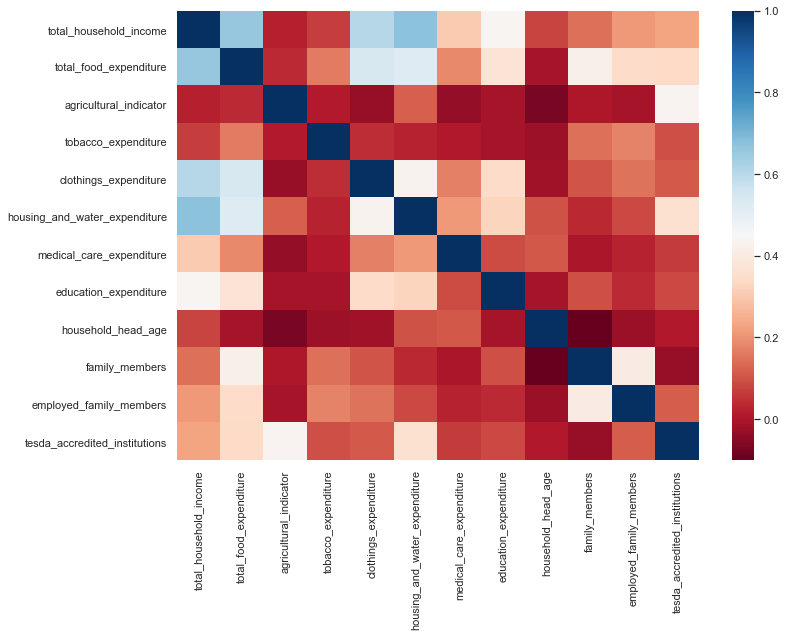

In [178]:
corr = income_df.corr()
# Make figure size larger
sns.set(rc={'figure.figsize':(11.7,8.27)})

# using seaborn to plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [180]:
income_df.replace([np.inf, -np.inf], np.nan).dropna(how="all")

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,medical_care_expenditure,education_expenditure,house_hold_sex,household_head_age,house_hold_head_marital_status,household_head_highest_grade,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,tesda_accredited_institutions
0,480332,CAR,117848,Wage/Salaries,0,0,4607,63636,3457,36200,Female,49,Single,Teacher Training and Education Sciences Programs,With Job/Business,Extended Family,4,1,100
1,198235,CAR,67766,Wage/Salaries,0,2132,8230,41370,3520,29300,Male,40,Married,Transport Services Programs,With Job/Business,Single Family,3,2,100
2,82785,CAR,61609,Wage/Salaries,1,4525,2735,14340,70,425,Male,39,Married,Grade 3,With Job/Business,Single Family,6,3,100
3,107589,CAR,78189,Wage/Salaries,0,0,1390,16638,60,300,Male,52,Married,Elementary Graduate,With Job/Business,Single Family,3,2,100
4,189322,CAR,94625,Wage/Salaries,0,0,4620,31122,140,0,Male,65,Married,Elementary Graduate,With Job/Business,Single Family,4,2,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41539,163444,IX,80172,Enterpreneurial Activities,2,0,5000,18948,8520,4610,Male,62,Married,Grade 2,With Job/Business,Extended Family,6,0,139
41540,203560,IX,82482,Wage/Salaries,2,1170,2155,19260,39706,1840,Male,55,Married,Second Year High School,With Job/Business,Single Family,5,2,139
41541,246510,IX,109521,Enterpreneurial Activities,2,4810,3442,20448,557,3440,Male,51,Married,Grade 5,With Job/Business,Single Family,7,0,139
41542,285300,IX,149327,Enterpreneurial Activities,2,7800,6945,26580,2104,16260,Male,30,Married,Second Year High School,With Job/Business,Extended Family,12,1,139


### multicolinearity

In [179]:
# assign to life_df_before to keep the cleaned data
income_df_before = income_df

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(income_df_before)

# create the series for before
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

# display the series
display(series_before)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [110]:
# Assign columns to X and Y
X = income_df.drop(['Total Household Income'], axis = 1)
Y = income_df[['Total Household Income']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)